Размерность (форма) датасета:  (241, 4)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Точность модели:  -8.821619776429674
ПРОГНОЗ на следующий шаг: [148.9333153] 



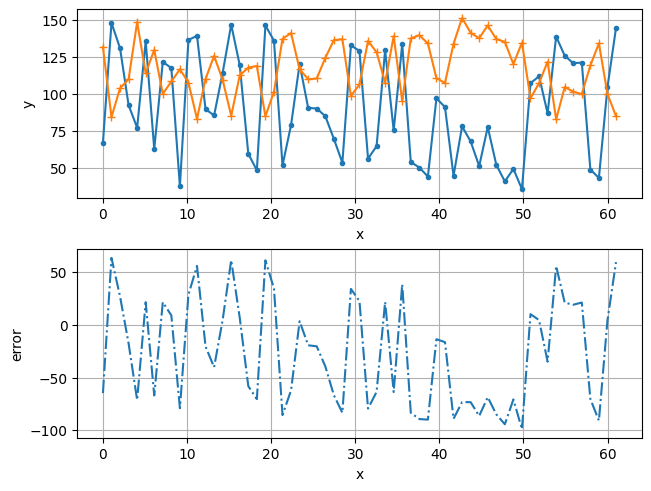

In [1]:
# ________  Простой прогноз курса доллара по данным "дата-курс"________
# Вначале в рабочее прстранство загрузите файл данных "курс_доллара2022.xlsx"
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import os
import seaborn as sns

df = pd.read_excel('/content/курс_доллара2022.xlsx') # загрузка таблицы с курсом $
# Для справки: имена столбцов таблицы: Open	High	Low	Close

# смотрим тепловую матрицу heatmap - она должна быть однотонной,в противном случае
# при желтых полосках надо устранить наличие пустых ячеек в таблице
#sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

df=np.array(df)  # преобразуем в тип numpy.ndarray для работы с данными как с массивом
data=df[:,0:-1]  # берем все столбцы, кроме последнего - в нем даты
print('Размерность (форма) датасета: ',data.shape)

# Определяем ВХОДЫ-ВЫХОДЫ
# вместо даты в курсе валюты будем использовать их порядковый номер (номера отсчетов)
t=np.linspace ( 0 , data.shape[0] , data.shape[0])  # генерация номеров отсчетов по количеству строк в data
# пристыковываем столбцец t слева к data
# изменяем форму t, так как она у него сейчас (n,) а надо (n,1)
# -1 означает, что строки неизвестны (формируй как угодно), а 1 - что должен быть один столбец!
# для многмерного ряда этого не делать, просто записать t=data[:,0:n], где n - число компонент ряда
t=t.reshape(-1, 1)
data=np.hstack([t,data]) # пристыковка t слева к data, делаем это для примера формирования общего датасета
# Будем считать что ВХОД x это t, т.е. x=t, а ВЫХОД y=Close - последний столбец
x=data[:,0]  # присвоили x=t
x=x.reshape(-1, 1)
y=data[:,-1]
# разбиваем данные на обучающие и тестирующие
X_train, X_test, y_train, y_test = train_test_split(x, y,random_state=1)
# Многослойный персептронный регрессор
# в скобках: кол. чисел=кол. слоев, числа=кол. нейронов в слое
regr = MLPRegressor(hidden_layer_sizes=(10,7,15),random_state=1, max_iter=500).fit(X_train, y_train)
print('\nТочность модели: ',regr.score(X_test, y_test))

# __ ПРОГНОЗ на следующий шаг____
# чтобы подать на вход сети одно число, его надо сделать как массив 1х1, чтобы
# соответствовать форме входных данных, на которых обучалась сеть
t_pr=np.array(1);t_pr=t_pr.reshape(-1, 1)
delay=2  # интервал прогноза - количество отсчетов за пределами исх. данных
t_pr[0,0]=x[-1,-1]+delay
Yr=regr.predict(t_pr)  # расчет проноза в одной точке
print('ПРОГНОЗ на следующий шаг:',Yr,'\n')

# Визуализация результатов
Yr=regr.predict(X_test)  # вычисляем выход модели на тестовых данных
fig, axs = plt.subplots(2, 1, layout='constrained')
t1=np.linspace ( 0 , Yr.shape[0] , Yr.shape[0])  # сделали для откладывания по оси абсцис
axs[0].plot(t1,Yr,'.-',t1,y_test,'+-')
axs[0].set_xlabel('x');axs[0].set_ylabel('y');axs[0].grid(True)

axs[1].plot(t1, (Yr-y_test),'-.')
#axs[1].set_xlim(0, 2)
axs[1].set_xlabel('x');axs[1].set_ylabel('error');axs[1].grid(True)
plt.show()

In [2]:
# ________  Сложный прогноз курса доллара на основе многомерного входа ________
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import os
import seaborn as sns

df = pd.read_excel('/content/курс_доллара2022.xlsx') # загрузка таблицы с курсом $
# Для справки: имена столбцов таблицы: Open	High	Low	Close

# смотрим тепловую матрицу heatmap - она должна быть однотонной,в противном случае
#sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
# при желтых полосках надо устранить наличие пустых ячеек в таблице

df=np.array(df)  # преобразуем в тип numpy.ndarray для работы с данными как с массивом
data=df[:,0:-1]  # берем все столбцы, кроме последнего - в нем даты
#print('Размерность (форма) датасета: ',data.shape)

# Определяем ВХОДЫ-ВЫХОДЫ
# ВХОД - это k значений от текущего i-го момента времени назад для Close, например,
# при k=5: x[i-5],x[i-4]x[i-3],x[i-2]x[i-1],x[i] - входной вектор имеет размер 6
# ВЫХОД  y=Close - последний столбец в момент времени через delay позиций от i-го,
# то есть delay - интервал прогноза
nn=np.array(data.shape) # считываем размеры датасета
n=nn[0,]                # количество строк в таблице данных
F=data[:,-1];           # берем последний столбец с Close для дальнейшего расмотрения
F=F.reshape(-1, 1)      # изменяем форму с (n,) на (n,1)
#print('F = ',F.shape)
k=5         # количество исторических значений курса, на которых строится прогноз
delay=3     # интервал прогноза

# формируем датасет ВХОД - матрицу, у которой в каждой cтроке по (k+1)значений,
# причем k первых значений это входы, а последнее - выход
x=np.zeros((n-k,k+1)) # шаблон для датасета
for i in range(0, n-k):
    x[i,:]=F[i:i+k+1,0]

# формируем датасет ВЫХОД - столбец, у которой значение сдвинуто вперед на delay
y=np.zeros((n-k-delay,1)) # шаблон для датасета y
for i in range(0, n-k-delay):
    y[i,:]=F[i+k+delay,0]

# отрезаем лишние строки снизу от х на величину прогноза delay
x=x[0:-1-delay+1,:]

# разбиваем данные на обучающие и тестирующие
X_train, X_test, y_train, y_test = train_test_split(x, y,random_state=1)

# Многослойный персептронный регрессор
regr = MLPRegressor(hidden_layer_sizes=(10,7,15),random_state=1, max_iter=500).fit(X_train, y_train)
print('\nТочность модели: ',regr.score(X_test, y_test))

# Визуализация результатов
Yr=regr.predict(X_test)  # вычисляем выход модели на тестовых данных
fig, axs = plt.subplots(3, 1, layout='constrained')
DD=regr.loss_curve_
axs[0].plot(DD);axs[0].set_xlabel('номер эпохи обучения')
axs[0].set_ylabel('loss - ошибка сети');axs[0].grid(True)

t1=np.linspace ( 0 , Yr.shape[0] , Yr.shape[0]) # для откладывания по оси абсцис
axs[1].plot(t1,Yr,'.-',t1,y_test,'+-')
axs[1].set_xlabel('номер отсчета');axs[1].set_ylabel('Курс');axs[1].grid(True)

Yr=Yr.reshape(-1, 1)
axs[2].plot(t1, (Yr-y_test),'-.')
axs[2].set_xlabel('x');axs[2].set_ylabel('Ошибка');axs[2].grid(True)

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Точность модели:  0.6810358647607562
